# Actividad evaluable del módulo 5: Completar frases mediante LSTM

Ahora que tenemos un marco para trabajar con datos secuenciales en PyTorch, nos centraremos en mejorar un modelo diseñado para completar frases. Para ello, introduciremos una codificación del conjunto de datos y una arquitectura de red neuronal más sofisticadas.

En esta actividad, deberá implementar un modelo LSTM que contenga 2 capas ocultas y que complete frases al nivel de codificación de palabras en vez de al nivel de caracteres. Le proporcionaremos el código necesario para limpiar y preparar los datos, así como algunas funciones de ayuda que le permitan completar la tarea.

## Conjunto de datos y codificación

Utilizaremos el mismo conjunto de datos, pero ahora los objetivos de la secuencia serán las frases en español.

In [178]:
from io import open
import unicodedata
import string
import random
import re

import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Subset
from torch.utils.data import TensorDataset, DataLoader
import time, copy
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [179]:
# Descargar y descomprimir el archivo de texto que contiene las frases traducidas
!rm spa-eng.zip _about.txt spa.txt
!wget https://www.manythings.org/anki/spa-eng.zip
!unzip spa-eng.zip
!ls

--2023-11-22 18:57:43--  https://www.manythings.org/anki/spa-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5394805 (5.1M) [application/zip]
Saving to: ‘spa-eng.zip’

spa-eng.zip         100%[===================>]   5.14M  27.6MB/s    in 0.2s    

2023-11-22 18:57:43 (27.6 MB/s) - ‘spa-eng.zip’ saved [5394805/5394805]

Archive:  spa-eng.zip
  inflating: _about.txt              
  inflating: spa.txt                 
_about.txt  sample_data  spa-eng.zip  spa.txt


In [180]:
# Funciones de ayuda combinadas del tutorial de PyTorch: https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html

# Convertir una string de Unicode a ASCII plano, gracias a
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Convertir los caracteres a minúsculas, recortar y eliminar todos los caracteres que no sean letras
# Este paso es importante para que todas las palabras tengan el mismo formato,
# igual que sucede al normalizar imágenes
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r"", s)
    s = re.sub(r"[^a-zA-Z.!'?]+", r" ", s)
    return s

def parse_data(filename):
    # Leer el archivo y dividir en líneas
    lines = open(filename, encoding='utf-8').read().strip().split('\n')

    # Dividir cada línea en pares y normalizar
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]
    # Eliminar la atribución, porque no forma parte de los datos
    pairs = [[pair[0], pair[1]] for pair in pairs]

    return pairs

In [181]:
pairs = parse_data("spa.txt")
# Solo nos interesan las frases en inglés, porque no vamos a traducir
spanish_sentences = [pair[1] for pair in pairs]
# Mezclar el conjunto de datos
random.shuffle(spanish_sentences)
print("Number of English sentences:", len(spanish_sentences))

Number of English sentences: 140868


In [182]:
len(spanish_sentences)

140868

In [ ]:
print(spanish_sentences[:1000])

In [184]:
# Como ya hemos mezclado el conjunto de datos, tomamos una muestra aleatoria de frases para los conjuntos de entrenamiento, validación y prueba
# Aquí, utilizamos un número pequeño de frases para reducir el tiempo de entrenamiento, pero puede usar más si lo desea
train_sentences = spanish_sentences[:1000]
val_sentences = spanish_sentences[1000:2000]
test_sentences = spanish_sentences[2000:3000]

# Mediante esta función, crearemos un diccionario para utilizarlo con los vectores de codificación one-hot
def add_words_to_dict(word_dictionary, word_list, sentences):
    for sentence in sentences:
        for word in sentence.split(" "):
            if word in word_dictionary:
                continue
            else:
                word_list.append(word)
                word_dictionary[word] = len(word_list)-1

spanish_dictionary = {}
spanish_list = []
add_words_to_dict(spanish_dictionary, spanish_list, train_sentences)
add_words_to_dict(spanish_dictionary, spanish_list, val_sentences)
add_words_to_dict(spanish_dictionary, spanish_list, test_sentences)



### Codificación

In [185]:
# Crear las muestras de entrenamiento
def create_input_tensor(sentence, word_dictionary):
    words = sentence.split(" ")
    tensor = torch.zeros(len(words), 1, len(word_dictionary)+1)
    for idx in range(len(words)):
        word = words[idx]
        tensor[idx][0][word_dictionary[word]] = 1
    return tensor

def create_target_tensor(sentence, word_dictionary):
    words = sentence.split(" ")
    tensor = torch.zeros(len(words), 1, len(word_dictionary)+1)
    for idx in range(1, len(words)):
        word = words[idx]
        tensor[idx-1][0][word_dictionary[word]] = 1
    tensor[len(words)-1][0][len(word_dictionary)] = 1 # EOS
    return tensor


train_tensors = [(create_input_tensor(sentence, spanish_dictionary), create_target_tensor(sentence, spanish_dictionary)) for sentence in train_sentences]
val_tensors = [(create_input_tensor(sentence, spanish_dictionary), create_target_tensor(sentence, spanish_dictionary)) for sentence in val_sentences]
test_tensors = [(create_input_tensor(sentence, spanish_dictionary), create_target_tensor(sentence, spanish_dictionary)) for sentence in test_sentences]

In [ ]:
print(train_sentences)

In [187]:
def tensor_to_sentence(word_list, tensor):
    sentence = ""
    for i in range(tensor.size(0)):
        topv, topi = tensor[i].topk(1)
        if topi[0][0] == len(word_list):
            sentence += "<EOS>"
            break
        sentence += word_list[topi[0][0]]
        sentence += " "
    return sentence

print("This code helps visualize what an input and it's corresponding target should look like!")
for input, target in train_tensors:
    print(tensor_to_sentence(spanish_list, input))
    print(tensor_to_sentence(spanish_list, target))
    break


This code helps visualize what an input and it's corresponding target should look like!
tom no pretendia que pasara esto 
no pretendia que pasara esto <EOS>


In [188]:
dataloaders = {'train': train_tensors,
               'val': val_tensors,
               'test': test_tensors}

dataset_sizes = {'train': len(train_tensors),
                 'val': len(val_tensors),
                 'test': len(test_tensors)}
print(f'dataset_sizes = {dataset_sizes}')

dataset_sizes = {'train': 1000, 'val': 1000, 'test': 1000}


### Definición de la LSTM

Incluya su modelo en esta sección. La estructura básica ya está creada.


In [189]:
#hiddenp = lstm.initHidden()

In [190]:
#hiddenp

In [191]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers = 2, dropout=0.5)
        #self.dropout = nn.Dropout(0.2)

        #self.lstm = nn.LSTM(input_size, hidden_size, num_layers = 1, nonlinearity = 'tanh', dropout = 0)

        self.fc = nn.Linear(hidden_size, output_size,)

    def forward(self, input, hidden):
        output, hidden = self.lstm(input, hidden)
        #output = self.fc(self.dropout(output))
        output = self.fc(output)

        return output, hidden

    def initHidden(self):
        # Necesitamos dos capas ocultas por la lstm de dos capas
        # El modelo debería ser capaz de utilizar esta implementación de initHidden()
        return (torch.zeros(2, self.hidden_size).to(device), torch.zeros(2, self.hidden_size).to(device))

In [192]:
for input, targer in dataloaders['train']:
  input = input

In [193]:
# COMPLETAR

lstm = LSTM(input.size(-1), 700, input.size(-1)).to(device)



In [194]:
print(lstm)

LSTM(
  (lstm): LSTM(3658, 700, num_layers=2, dropout=0.5)
  (fc): Linear(in_features=700, out_features=3658, bias=True)
)


In [195]:
def train_lstm(model, dataloaders, dataset_sizes, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict()) # Almacenar los mejores pesos por separado
    best_loss = np.inf
    best_epoch = 0

    # Cada ciclo tiene una fase de entrenamiento, validación y prueba
    phases = ['train', 'val', 'test']

    # Hacer un seguimiento de la evolución de la pérdida durante el entrenamiento
    training_curves = {}
    for phase in phases:
        training_curves[phase+'_loss'] = []

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in phases:
            if phase == 'train':
                model.train()  # Configurar el modelo en modo de entrenamiento
            else:
                model.eval()   # Configurar el modelo en modo de evaluación

            running_loss = 0.0

            # Iterar con los datos
            for input_sequence, target_sequence in dataloaders[phase]:
                # Ahora, iterar con cada secuencia

                hidden = model.initHidden() # Empezar con un estado oculto nuevo

                current_input_sequence = input_sequence.to(device)
                current_target_sequence = target_sequence.to(device)

                # Poner a cero los gradientes de los parámetros
                optimizer.zero_grad()

                # Método forward
                with torch.set_grad_enabled(phase == 'train'):
                    loss = 0
                    # Hacer una predicción de cada elemento de la secuencia
                    # y llevar un seguimiento del estado oculto a lo largo del proceso
                    #print('antes')
                    for i in range(current_input_sequence.size(0)):
                        # Debemos pensar bien cómo transferir las capas ocultas al dispositivo
                        #print('entro')
                        current_hidden = (hidden[0].to(device), hidden[1].to(device))  #diferente.
                        #print('despues')
                        #current_hidden = hidden.to(device)
                        output, hidden = model(current_input_sequence[i], current_hidden)
                        #print('vamos bien')
                        l = criterion(output, current_target_sequence[i])
                        loss += l

                    # Método backward y actualización de los pesos solo si está en la fase de entrenamiento al final de una secuencia
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Estadísticas
                running_loss += loss.item() / current_input_sequence.size(0)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            training_curves[phase+'_loss'].append(epoch_loss)

            print(f'{phase:5} Loss: {epoch_loss:.4f}')

            # Hacer una copia profunda del modelo si tenemos la mejor pérdida
            # Nota: utilizamos la pérdida de entrenamiento para seleccionar el mejor modelo
            if phase == 'train' and epoch_loss < best_loss:
              best_epoch = epoch
              best_loss = epoch_loss
              best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Loss: {best_loss:4f} at epoch {best_epoch}')

    # Cargar los mejores pesos del modelo
    model.load_state_dict(best_model_wts)

    return model, training_curves

In [196]:
# Definir la mejor función de predicción para poder ejecutar algunas predicciones en la misma celda que el entrenamiento
def predict(model, word_dictionary, word_list, input_sentence, max_length = 20):
    output_sentence = input_sentence + " "
    tensor = create_input_tensor(input_sentence, word_dictionary)
    hidden = model.initHidden()
    current_input_sequence = tensor.to(device)
    input = None

    for i in range(current_input_sequence.size(0)):
        current_hidden = (hidden[0].to(device), hidden[1].to(device))
        #current_hidden = hidden.to(device)
        output, hidden = model(current_input_sequence[i], current_hidden)

    topv, topi = output.topk(1)
    topi = topi[0][0]
    if topi ==  len(word_dictionary):
        topv, topi = output.topk(2)
        topi = topi[0][1]
    word = word_list[topi]
    output_sentence += word
    output_sentence += " "
    input = create_input_tensor(word, word_dictionary)

    for i in range(len(input_sentence.split(" ")), max_length):
        current_hidden = (hidden[0].to(device), hidden[1].to(device))
        #current_hidden = hidden.to(device)
        current_input = input[0].to(device)
        output, hidden = model(current_input, current_hidden)
        topv, topi = output.topk(1)
        topi = topi[0][0]
        if topi == len(word_dictionary):
            # Imprimir ("Hit the EOS")
            break
        word = word_list[topi]
        output_sentence += word
        output_sentence += " "
        input = create_input_tensor(word, word_dictionary)
    return output_sentence

In [197]:
learning_rate = 0.001
num_epochs = 20

# COMPLETAR
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
# Complete el código necesario para ejecutar la función de entrenamiento

lstm, training_curves = train_lstm(lstm, dataloaders, dataset_sizes,
                                     criterion, optimizer, scheduler, num_epochs=num_epochs)




Epoch 1/20
----------
train Loss: 6.1476
val   Loss: 5.9952
test  Loss: 6.0132

Epoch 2/20
----------
train Loss: 5.0565
val   Loss: 6.4137
test  Loss: 6.4746

Epoch 3/20
----------
train Loss: 4.5529
val   Loss: 6.9835
test  Loss: 7.0318

Epoch 4/20
----------
train Loss: 4.0836
val   Loss: 7.1239
test  Loss: 7.1899

Epoch 5/20
----------
train Loss: 3.6330
val   Loss: 7.4312
test  Loss: 7.4991

Epoch 6/20
----------
train Loss: 3.1691
val   Loss: 7.9426
test  Loss: 8.0542

Epoch 7/20
----------
train Loss: 2.7386
val   Loss: 8.1645
test  Loss: 8.2713

Epoch 8/20
----------
train Loss: 2.3826
val   Loss: 8.6304
test  Loss: 8.7695

Epoch 9/20
----------
train Loss: 2.0383
val   Loss: 8.8788
test  Loss: 8.9949

Epoch 10/20
----------
train Loss: 1.7565
val   Loss: 9.1335
test  Loss: 9.2726

Epoch 11/20
----------
train Loss: 1.5241
val   Loss: 9.3155
test  Loss: 9.4557

Epoch 12/20
----------
train Loss: 1.3395
val   Loss: 9.5692
test  Loss: 9.7300

Epoch 13/20
----------
train Loss: 1

In [203]:
print(predict(lstm, spanish_dictionary, spanish_list, "mary"))
print(predict(lstm, spanish_dictionary, spanish_list, "tom esta"))

mary se vino conmigo 
tom esta interesado en el montanismo 


In [ ]:
print(train_sentences)
print(val_sentences)
print(test_sentences)

### Visualizar los resultados

Observe las curvas de entrenamiento. ¿Su modelo se sobreajusta a los datos de entrenamiento? Si es así, ¿por qué cree que sucede? Escriba su respuesta en la celda de abajo.

Escriba aquí su respuesta:

In [209]:
def plot_training_curves(training_curves,
                         phases=['train', 'val', 'test'],
                         metrics=['loss']):
    epochs = list(range(len(training_curves['train_loss'])))
    for metric in metrics:
        plt.figure()
        plt.title(f'Training curves - {metric}')
        for phase in phases:
            key = phase+'_'+metric
            if key in training_curves:
                plt.plot(epochs, training_curves[key])
        plt.xlabel('epoch')
        plt.legend(labels=phases)

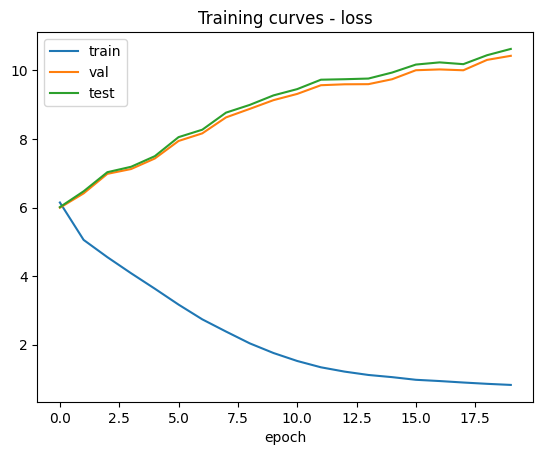

In [210]:
plot_training_curves(training_curves, phases=['train', 'val', 'test'])

Conclusión

Si observamos la curva de entrenamiento vemos que si hay sobre ajuste ya que mientras que el error disminuye en el entrenamiento este aumenta en el val y test, si hicieron varias pruebas con otras capas y dropout pero no se logró eliminar el sobre ajuste, por lo que se concluye que no predice inteligentemente porque se necesita más información para entrenar nuestro modelo y así poder eliminar el sobreajuste y hacer que nuestro modelo realice predicción inteligentes.

